## Setup

In [1]:
%load_ext autoreload

In [16]:
%autoreload 2

from functools import partial
import math

from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neighbors import KernelDensity
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import clone
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

import numpy as np
import seaborn as sns
import scipy
import pandas as pd

from machine_learning.ml_data import MLData
from machine_learning.sklearn import year_cv_split, ColumnDropper, EloRegressor, TeammatchToMatchConverter
from machine_learning.ml_estimators import StackingEstimator
from machine_learning.settings import TEAM_NAMES, ROUND_TYPES, VENUES, CATEGORY_COLS
from machine_learning.ml_estimators.stacking_estimator import ELO_MODEL_COLS

YEAR_RANGE = (2005, 2015)

In [3]:
data = MLData()
data.data

/usr/local/lib/python3.6/site-packages/kedro/context/context.py:327: UserWarning: Credentials not found in your Kedro project config.
No files found in ['/app/conf/base', '/app/conf/development'] matching the glob pattern(s): ['credentials*', 'credentials*/**']
  str(exc)


2019-12-17 23:25:12,928 - kedro.io.data_catalog - INFO - Loading data from `model_data` (JSONLocalDataSet)...


team   oppo_team round_type  \
Adelaide         1991 1           Adelaide    Hawthorn    Regular   
                      2           Adelaide     Carlton    Regular   
                      3           Adelaide      Sydney    Regular   
                      4           Adelaide    Essendon    Regular   
                      5           Adelaide  West Coast    Regular   
...                                    ...         ...        ...   
Western Bulldogs 2019 20  Western Bulldogs    Brisbane    Regular   
                      21  Western Bulldogs    Essendon    Regular   
                      22  Western Bulldogs         GWS    Regular   
                      23  Western Bulldogs    Adelaide    Regular   
                      24  Western Bulldogs         GWS     Finals   

                                      venue prev_match_oppo_team match_id  \
Adelaide         1991 1       Football Park                    0    10128   
                      2       Football Park             Hawthorn    10135   
                      3              S.C.G.              Carlton    10143   
                      4          Windy Hill               Sydney    10147   
                      5             Subiaco             Essendon    10159   
...                                     ...                  ...      ...   
Western Bulldogs 2019 20              Gabba            Fremantle    15578   
                      21          Docklands             Brisbane    15583   
                      22  Sydney Showground             Essendon    15595   
                      23     Eureka Stadium                  GWS    15603   
                      24  Sydney Showground             Adelaide    15608   

                                              date  team_goals  team_behinds  \
Adelaide         1991 1  1991-03-22 03:56:00+00:00          24            11   
                      2  1991-03-31 03:56:00+00:00          12             9   
                      3  1991-04-07 03:05:00+00:00          19            18   
                      4  1991-04-13 03:30:00+00:00           6            11   
                      5  1991-04-21 05:27:00+00:00           9            11   
...                                            ...         ...           ...   
Western Bulldogs 2019 20 2019-08-04 02:58:00+00:00          11            14   
                      21 2019-08-10 03:30:00+00:00          21            11   
                      22 2019-08-18 03:05:00+00:00          19            12   
                      23 2019-08-25 03:30:00+00:00          18            13   
                      24 2019-09-07 03:05:00+00:00           8             7   

                          score  ...  \
Adelaide         1991 1     155  ...   
                      2      81  ...   
                      3     132  ...   
                      4      47  ...   
                      5      65  ...   
...                         ...  ...   
Western Bulldogs 2019 20     80  ...   
                      21    137  ...   
                      22    126  ...   
                      23    121  ...   
                      24     55  ...   

                          oppo_rolling_prev_match_goals_divided_by_rolling_prev_match_goals_plus_rolling_prev_match_behinds  \
Adelaide         1991 1                                                 0.0                                                   
                      2                                                 0.0                                                   
                      3                                                 0.0                                                   
                      4                                                 0.0                                                   
                      5                                                 0.0                                                   
...                                                                     ...     

In [3]:
leg_data = MLData(
    pipeline="legacy",
    data_set="legacy_model_data",
)
leg_data.data

2019-12-17 05:04:49,458 - kedro.io.data_catalog - INFO - Loading data from `legacy_model_data` (JSONLocalDataSet)...


/usr/local/lib/python3.6/site-packages/kedro/context/context.py:327: UserWarning: Credentials not found in your Kedro project config.
No files found in ['/app/conf/base', '/app/conf/development'] matching the glob pattern(s): ['credentials*', 'credentials*/**']
  str(exc)


team   oppo_team round_type  \
Adelaide         1991 1           Adelaide    Hawthorn    Regular   
                      2           Adelaide     Carlton    Regular   
                      3           Adelaide      Sydney    Regular   
                      4           Adelaide    Essendon    Regular   
                      5           Adelaide  West Coast    Regular   
...                                    ...         ...        ...   
Western Bulldogs 2019 20  Western Bulldogs    Brisbane    Regular   
                      21  Western Bulldogs    Essendon    Regular   
                      22  Western Bulldogs         GWS    Regular   
                      23  Western Bulldogs    Adelaide    Regular   
                      24  Western Bulldogs         GWS     Finals   

                                      venue                      date  \
Adelaide         1991 1       Football Park 1991-03-22 03:56:00+00:00   
                      2       Football Park 1991-03-31 03:56:00+00:00   
                      3              S.C.G. 1991-04-07 03:05:00+00:00   
                      4          Windy Hill 1991-04-13 03:30:00+00:00   
                      5             Subiaco 1991-04-21 05:27:00+00:00   
...                                     ...                       ...   
Western Bulldogs 2019 20              Gabba 2019-08-04 02:58:00+00:00   
                      21          Docklands 2019-08-10 03:30:00+00:00   
                      22  Sydney Showground 2019-08-18 03:05:00+00:00   
                      23     Eureka Stadium 2019-08-25 03:30:00+00:00   
                      24  Sydney Showground 2019-09-07 03:05:00+00:00   

                          team_goals  team_behinds  score  oppo_team_goals  \
Adelaide         1991 1           24            11    155                9   
                      2           12             9     81               15   
                      3           19            18    132               15   
                      4            6            11     47               12   
                      5            9            11     65               19   
...                              ...           ...    ...              ...   
Western Bulldogs 2019 20          11            14     80               14   
                      21          21            11    137                4   
                      22          19            12    126                9   
                      23          18            13    121               13   
                      24           8             7     55               16   

                          oppo_team_behinds  ...  win_odds  oppo_win_odds  \
Adelaide         1991 1                  15  ...      0.00           0.00   
                      2                  14  ...      0.00           0.00   
                      3                  18  ...      0.00           0.00   
                      4                  20  ...      0.00           0.00   
                      5                  16  ...      0.00           0.00   
...                                     ...  ...       ...            ...   
Western Bulldogs 2019 20                 14  ...      3.15           1.36   
                      21                  9  ...      1.68           2.20   
                      22                 11  ...      2.15           1.71   
                      23                  9  ...      1.33           3.35   
                      24                 17  ...      2.00           1.82   

                          line_odds  oppo_line_odds  betting_pred_win  \
Adelaide         1991 1         0.0             0.0               0.0   
                      2         0.0             0.0               0.0   
                      3         0.0             0.0               0.0   
                      4         0.0             0.0               0.0   
                      5         0.0             0.0               0.0   
...                             

In [59]:
se = StackingEstimator()
se

StackingEstimator(name='stacking_estimator',
                  pipeline=<baikal.sklearn.SKLearnWrapper object at 0x7f68971164a8>)

In [9]:
X_train, y_train = data.train_data
X_test, y_test = data.test_data

In [5]:
def _make_cv_prediction(estimator, X, y, train, test):
    X_train, y_train = X[train], y[train]
    X_test = X[test]
    estimator.fit(X_train, y_train)
    return estimator.predict(X_test)

def time_series_cross_val_predict(estimator, X, y, cv):
    make_cv_prediction = partial(_make_cv_prediction, estimator, X, y)

    return np.array([make_cv_prediction(train, test) for train, test in cv])

In [6]:
LOG_BASE = 2
MIN_VAL = 1 * 10**-10

def _calculate_bits(row):
    if row['home_pred'] > row['away_pred']:
        predicted_win_proba = row['home_pred']
        predicted_home_win = True
    else:
        predicted_win_proba = row['away_pred']
        predicted_home_win = False

    correct = (predicted_home_win and row['home_win']) or (not predicted_home_win and not row['home_win'])

    if row['draw']:
        return 1 + (0.5 * math.log(max(predicted_win_proba * (1 - predicted_win_proba), MIN_VAL), LOG_BASE))

    if correct:
        return 1 + math.log(max(row['home_pred'], MIN_VAL), LOG_BASE)

    return 1 + math.log(max(1 - predicted_win_proba, MIN_VAL), LOG_BASE)


def bits_scorer(estimator, X, y, y_pred=None):
    if y_pred is None:
        y_pred = estimator.predict(X)

    team_match_data_frame = X.assign(y_true=y.to_numpy(), y_pred=y_pred)
    home_match_data_frame = team_match_data_frame.query("at_home == 1").sort_index()
    away_match_data_frame = (
        team_match_data_frame.query("at_home == 0")
        .set_index(["oppo_team", "year", "round_number"])
        .rename_axis([None, None, None])
        .sort_index()
    )
    
    bits_data_frame = pd.DataFrame(
        {
            'home_win': home_match_data_frame["y_true"] > away_match_data_frame["y_true"],
            'draw': home_match_data_frame["y_true"] == away_match_data_frame["y_true"],
            'home_pred': home_match_data_frame["y_pred"],
            'away_pred': away_match_data_frame["y_pred"],
        }
    )
    
    return bits_data_frame.apply(_calculate_bits, axis=1)

def neg_bits_eval_func(X, y_true, y_pred):
    team_match_data_frame = X.assign(y_true=y_true.to_numpy(), y_pred=y_pred)
    home_match_data_frame = team_match_data_frame.query("at_home == 1").sort_index()
    away_match_data_frame = (
        team_match_data_frame.query("at_home == 0")
        .set_index(["oppo_team", "year", "round_number"])
        .rename_axis([None, None, None])
        .sort_index()
    )
    
    bits_data_frame = pd.DataFrame(
        {
            'home_win': home_match_data_frame["y_true"] > away_match_data_frame["y_true"],
            'draw': home_match_data_frame["y_true"] == away_match_data_frame["y_true"],
            'home_pred': home_match_data_frame["y_pred"],
            'away_pred': away_match_data_frame["y_pred"],
        }
    )
    
    # Return negative bits, because XGB minimizes evaluation metric by default
    return 'neg_bits', bits_data_frame.apply(_calculate_bits, axis=1).sum() * -1

## Kernel Density Estimation

In [62]:
cv_y_preds = time_series_cross_val_predict(se, X_train, y_train, year_cv_split(X_train, YEAR_RANGE))

cv_y_preds

/usr/local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/site-packages/x

array([array([  8.853854  , -14.549452  ,  -8.060293  , -27.415987  ,
        10.883992  ,  10.511069  ,  -8.988924  ,  20.37259   ,
       -10.438218  ,  27.382515  ,  20.260603  , -30.22353   ,
         7.047629  ,  29.246231  ,  25.402061  ,  26.542831  ,
        -3.343442  ,  28.092234  ,  45.453514  ,   9.370649  ,
        51.319237  , -46.025043  , -15.9987335 ,  15.384421  ,
       -44.550144  ,  23.602337  , -14.549452  ,  18.832977  ,
        23.403217  ,   3.010338  ,  -4.222418  ,  37.05913   ,
       -18.57853   ,  26.369032  ,  36.945965  , -21.13331   ,
        10.511069  ,   4.4424205 ,  -3.8956075 ,  29.965048  ,
       -17.696682  ,  32.189392  ,   1.9413856 ,  47.04184   ,
        -6.195147  ,   7.189876  , -22.354269  ,   2.0938787 ,
         0.20455518,  16.102535  , -23.356113  ,  -9.509587  ,
        16.585611  ,  -4.222418  , -30.959795  , -16.967543  ,
       -30.187006  ,  -9.067351  , -13.346565  , -27.343647  ,
       -98.48287   , -48.50855   ,  -8.721794  ,

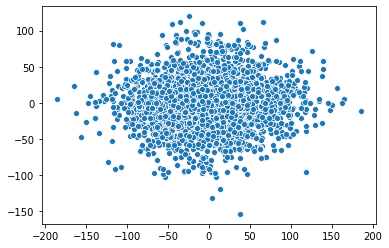

In [193]:
sns.scatterplot(
    x=y_train.loc[(slice(None), slice(YEAR_RANGE[0], YEAR_RANGE[1] - 1), slice(None))].to_numpy(),
    y=np.concatenate(cv_y_preds)
)

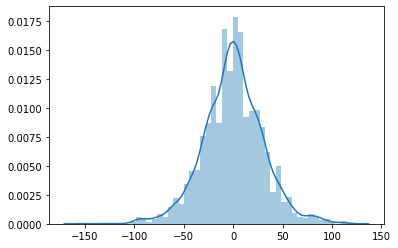

In [194]:
sns.distplot(np.concatenate(cv_y_preds))

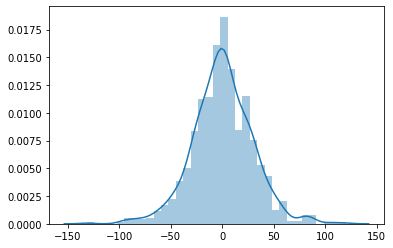

In [71]:
kd = KernelDensity()

kd.fit(np.concatenate(cv_y_preds[:-1]).reshape(-1, 1))
sample = kd.sample(n_samples=1000)

sns.distplot(sample.reshape(-1, 1))

In [209]:
np.concatenate(cv_y_preds).mean(), sample.mean()

(-0.00482386, 0.29624590737310824)

In [211]:
np.concatenate(cv_y_preds).std(), sample.std()

(30.384295, 29.791060848795155)

In [72]:
confidences = []

for pred in cv_y_preds[-1]:
    confidences.append(scipy.stats.percentileofscore(sample, pred) / 100)
    
conf_ar = np.array(confidences)
conf_ar

array([0.361, 0.276, 0.433, 0.237, 0.958, 0.49 , 0.983, 0.391, 0.644,
       0.582, 0.112, 0.35 , 0.456, 0.33 , 0.904, 0.478, 0.482, 0.845,
       0.804, 0.748, 0.33 , 0.983, 0.039, 0.13 , 0.216, 0.039, 0.218,
       0.218, 0.183, 0.218, 0.032, 0.149, 0.225, 0.816, 0.012, 0.039,
       0.071, 0.44 , 0.305, 0.451, 0.149, 0.039, 0.119, 0.013, 0.804,
       0.3  , 0.308, 0.816, 0.454, 0.644, 0.149, 0.635, 0.358, 0.804,
       0.117, 0.119, 0.816, 0.072, 0.921, 0.047, 0.149, 0.064, 0.61 ,
       0.379, 0.074, 0.162, 0.482, 0.33 , 0.391, 0.557, 0.51 , 0.675,
       0.748, 0.602, 0.738, 0.926, 0.964, 0.966, 0.218, 0.89 , 0.482,
       0.573, 0.51 , 0.309, 0.422, 0.939, 0.667, 0.064, 0.208, 0.448,
       0.728, 0.316, 0.897, 0.214, 0.746, 0.73 , 0.374, 0.482, 0.967,
       0.962, 0.573, 0.241, 0.105, 0.358, 0.645, 0.168, 0.382, 0.645,
       0.799, 0.834, 0.218, 0.454, 0.958, 0.38 , 0.654, 0.602, 0.867,
       0.744, 0.361, 0.644, 0.845, 0.865, 0.804, 0.989, 0.883, 0.969,
       0.997, 0.983,

In [73]:
X_val = X_train.query('year == 2014')
y_val = y_train.loc[(slice(None), 2014, slice(None))]

bits = bits_scorer(se, X_val, y_val, y_pred=conf_ar)
bits

Adelaide          2014  3    -0.207561
                        5     0.938098
                        7    -4.878321
                        9    -0.329160
                        11    0.219091
                                ...   
Western Bulldogs  2014  15    0.762136
                        17   -0.494109
                        18   -0.494109
                        22   -2.380822
                        23   -1.977100
Length: 207, dtype: float64

In [215]:
bits.sum()

-89.46589006065372

## Bootstrapping

In [235]:
BOOTSTRAP_YEAR_RANGE = (1966, 2015)

def bootstrap_predictions(estimator, X, y, year_range, n_iter=10, one_year=True):
    """Split data by year for cross-validation for time-series data"""

    test_years = np.random.choice(range(*year_range), n_iter)
    preds = []
    
    for year in test_years:
        X_train = X.query('year < @year')
        X_test = X.query('year == @year') if one_year else X.query('year >= @year')
        y_train = y.loc[X_train.index]
        
        boot_estimator = clone(estimator)
        boot_estimator.fit(X_train, y_train)
        preds.append(boot_estimator.predict(X_test))
        
    return np.concatenate(preds)

In [236]:
boot_preds = bootstrap_predictions(se, X_train, y_train, BOOTSTRAP_YEAR_RANGE)
boot_preds

/usr/local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/site-packages/x

array([ -0.17047137,  36.07781   ,  -6.998421  , ...,  -5.548377  ,
       -11.011564  , -47.328552  ], dtype=float32)

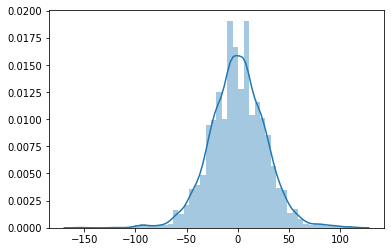

In [237]:
sns.distplot(boot_preds.reshape(-1, 1))

In [238]:
boot_preds.mean(), boot_preds.std()

(0.13059407, 26.967321)

In [239]:
confidences = []

for pred in cv_y_preds[-1]:
    confidences.append(scipy.stats.percentileofscore(boot_preds, pred) / 100)
    
boot_conf_ar = np.array(confidences)
boot_conf_ar

array([0.37485207, 0.27544379, 0.43934911, 0.23136095, 0.9704142 ,
       0.50887574, 0.99023669, 0.40059172, 0.65029586, 0.55857988,
       0.10059172, 0.36035503, 0.46863905, 0.33224852, 0.91863905,
       0.48994083, 0.49053254, 0.86627219, 0.82721893, 0.76775148,
       0.33224852, 0.99053254, 0.02840237, 0.12455621, 0.21597633,
       0.02810651, 0.21893491, 0.21893491, 0.17366864, 0.21893491,
       0.02278107, 0.15118343, 0.22307692, 0.83431953, 0.00650888,
       0.02751479, 0.05798817, 0.44497041, 0.3035503 , 0.46301775,
       0.15118343, 0.02751479, 0.11242604, 0.00650888, 0.82751479,
       0.29733728, 0.30946746, 0.83402367, 0.46804734, 0.65029586,
       0.15118343, 0.64112426, 0.37366864, 0.82751479, 0.11005917,
       0.11242604, 0.83431953, 0.05976331, 0.93579882, 0.03461538,
       0.15118343, 0.04911243, 0.6035503 , 0.38816568, 0.06390533,
       0.15976331, 0.49053254, 0.33224852, 0.40059172, 0.54733728,
       0.52071006, 0.68491124, 0.76775148, 0.59378698, 0.75414

In [240]:
bits = bits_scorer(se, X_val, y_val, y_pred=boot_conf_ar)
bits

Adelaide          2014  3    -0.186560
                        5     0.956673
                        7    -5.678413
                        9    -0.299692
                        11    0.159836
                                ...   
Western Bulldogs  2014  15    0.798793
                        17   -0.518236
                        18   -0.432789
                        22   -2.442037
                        23   -2.317666
Length: 207, dtype: float64

In [241]:
bits.sum()

-105.94727473597473

## Gaussian Process

In [7]:
gpc_slice = (slice(None), slice(1995, 2013), slice(None))

gpc = make_pipeline(
    ColumnDropper(cols_to_drop=ELO_MODEL_COLS),
    ColumnTransformer(
        [
            (
                "onehotencoder",
                OneHotEncoder(
                    categories=[TEAM_NAMES, TEAM_NAMES, ROUND_TYPES, VENUES],
                    sparse=False,
                    handle_unknown="ignore",
                ),
                CATEGORY_COLS,
            )
        ],
        remainder=StandardScaler(),
    ),
    GaussianProcessClassifier(copy_X_train=False)
)

gpc.fit(X_train.loc[gpc_slice, :], (y_train.loc[gpc_slice] >= 0).astype(int))

Pipeline(memory=None,
         steps=[('columndropper',
                 ColumnDropper(cols_to_drop=['prev_match_oppo_team',
                                             'oppo_prev_match_oppo_team',
                                             'prev_match_at_home',
                                             'oppo_prev_match_at_home',
                                             'date'])),
                ('columntransformer',
                 ColumnTransformer(n_jobs=None,
                                   remainder=StandardScaler(copy=True,
                                                            with_mean=True,
                                                            with_std=True),
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transfo...
                                                                handle_unknown='ignore',
                                            

In [10]:
gpc_y_pred = gpc.predict_proba(X_test)[:, 1]

bits = bits_scorer(gpc, X_test, (y_test >= 0).astype(int), y_pred=gpc_y_pred)
bits

Adelaide          2017  1     1.442647e-08
                        4     1.442647e-08
                        6     1.442647e-08
                        8    -1.442647e-08
                        10    1.442647e-08
                                  ...     
Western Bulldogs  2018  11   -1.442647e-08
                        14   -1.442647e-08
                        15    1.442647e-08
                        16   -1.442647e-08
                        19   -1.442647e-08
Length: 414, dtype: float64

In [11]:
bits.sum()

1.009852820477164e-06

In [12]:
gpc_y_pred

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.

## Estimate mean/error

In [77]:
dist_slice = (slice(None), slice(YEAR_RANGE[0], YEAR_RANGE[1] - 2), slice(None))

error_model = make_pipeline(
    ColumnDropper(cols_to_drop=ELO_MODEL_COLS),
    ColumnTransformer(
        [
            (
                "onehotencoder",
                OneHotEncoder(
                    categories=[TEAM_NAMES, TEAM_NAMES, ROUND_TYPES, VENUES],
                    sparse=False,
                    handle_unknown="ignore",
                ),
                CATEGORY_COLS,
            )
        ],
        remainder=StandardScaler(),
    ),
    KNeighborsRegressor()
)

validation_error = (
    y_train
    .loc[dist_slice]
    .to_numpy() - np.concatenate(cv_y_preds[:-1])
)**2
error_model.fit(X_train.loc[dist_slice, :], validation_error)

pred_mean = cv_y_preds[-1]
pred_std = error_model.predict(X_val)**0.5

pred_mean.mean(), pred_std.mean()

(-0.54628307, 48.085515716916994)

In [78]:
confidences = []

for pred, std in zip(pred_mean, pred_std):
    rv = scipy.stats.norm(loc=pred, scale=std)
    
    if pred > 0:
        confidences.append(1 - rv.cdf(0))
    else:
        confidences.append(rv.cdf(0))
        
err_conf_ar = np.array(confidences)
err_conf_ar

array([0.5582153 , 0.67262867, 0.52806196, 0.74670693, 0.7116656 ,
       0.50309713, 0.77920171, 0.56996455, 0.61948687, 0.53664058,
       0.92161312, 0.59060306, 0.51556273, 0.57126206, 0.80754996,
       0.50437086, 0.50342179, 0.78895947, 0.71067771, 0.62421334,
       0.57132221, 0.87869916, 0.8250028 , 0.66485329, 0.71515016,
       0.84535627, 0.63837835, 0.76103951, 0.65534729, 0.6344552 ,
       0.8544826 , 0.77507329, 0.75214468, 0.70847791, 0.86813048,
       0.83349401, 0.90087423, 0.52770237, 0.59331977, 0.53096142,
       0.78071186, 0.7952144 , 0.91170822, 0.8701954 , 0.67303309,
       0.61082162, 0.58006831, 0.65614826, 0.51471289, 0.62996184,
       0.69723018, 0.55691707, 0.5770079 , 0.7418404 , 0.74082442,
       0.77127977, 0.76763762, 0.86384531, 0.75861507, 0.90341798,
       0.69869705, 0.76705545, 0.58299003, 0.54638282, 0.82579196,
       0.81239798, 0.50318615, 0.55967731, 0.53778519, 0.53753909,
       0.50739735, 0.59029447, 0.63679269, 0.58761392, 0.65795

In [79]:
bits = bits_scorer(se, X_val, y_val, y_pred=err_conf_ar)
bits

Adelaide          2014  3     0.078779
                        5    -1.240130
                        7     0.640069
                        9    -0.277932
                        11   -0.227404
                                ...   
Western Bulldogs  2014  15    0.644207
                        17    0.484111
                        18    0.273520
                        22    0.553678
                        23    0.492853
Length: 207, dtype: float64

In [80]:
bits.sum()

-52.45332776995919

## XGBRegressor

In [128]:
conf_model = make_pipeline(
    ColumnDropper(cols_to_drop=ELO_MODEL_COLS),
    ColumnTransformer(
        [
            (
                "onehotencoder",
                OneHotEncoder(
                    categories=[TEAM_NAMES, TEAM_NAMES, ROUND_TYPES, VENUES],
                    sparse=False,
                    handle_unknown="ignore",
                ),
                CATEGORY_COLS,
            )
        ],
        remainder=StandardScaler(),
    ),
    XGBRegressor(objective='reg:squarederror')
)

conf_model.fit(
    X_train,
    (y_train >= 0).astype(int),
    xgbregressor__eval_metric=neg_bits_eval_func,
)

xgb_y_val = (y_val >= 0).astype(int)
xgb_y_val

/usr/local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Adelaide          1     0
                  2     0
                  3     0
                  4     1
                  5     1
                       ..
Western Bulldogs  19    0
                  20    1
                  21    0
                  22    0
                  23    0
Name: margin, Length: 414, dtype: int64

In [129]:
bits = bits_scorer(conf_model, X_val, xgb_y_val)
bits

Adelaide          2014  3    -0.123905
                        5     0.693622
                        7    -1.536889
                        9    -0.433535
                        11    0.308842
                                ...   
Western Bulldogs  2014  15    0.512390
                        17   -0.373553
                        18   -0.230392
                        22   -1.502051
                        23   -0.974215
Length: 207, dtype: float64

In [130]:
bits.sum()

-17.90742104063944

## ELO

In [17]:
elo = make_pipeline(TeammatchToMatchConverter(), EloRegressor())
elo.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('teammatchtomatchconverter',
                 TeammatchToMatchConverter(match_cols=['date', 'venue',
                                                       'round_type'])),
                ('eloregressor',
                 EloRegressor(home_ground_advantage=9, k=35.6, m=130, s=250,
                              season_carryover=0.575, x=0.49))],
         verbose=False)

In [18]:
bits = bits_scorer(elo, X_test, y_test)
bits

Adelaide          2017  1     0.052172
                        4     0.304504
                        6     0.252223
                        8    -0.274445
                        10    0.230488
                                ...   
Western Bulldogs  2018  11   -0.197989
                        14   -0.160886
                        15   -0.197989
                        16   -0.110214
                        19   -0.160886
Length: 414, dtype: float64

In [19]:
bits.sum()

4.170846213767291